# Notebook 07: Predictive Modeling & Machine Learning

**Objective**: Build predictive models for Digimon characteristics using machine learning.

This notebook explores:
- Classification tasks (predict Type, Attribute, evolution likelihood)
- Feature engineering from graph properties
- Model training and evaluation
- Feature importance analysis

---

## 1. Setup and Imports

In [20]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from collections import Counter, defaultdict
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Machine learning imports
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.multiclass import OneVsRestClassifier

# Try to import XGBoost, but make it optional
try:
    import xgboost as xgb
    HAS_XGBOOST = True
    print("XGBoost is available")
except Exception as e:  # Catch any exception, including XGBoostError
    print(f"Warning: XGBoost not available ({type(e).__name__}). Will use GradientBoosting as fallback.")
    HAS_XGBOOST = False
    xgb = None  # Define xgb as None to avoid NameError later

# Try to import SHAP, but make it optional
try:
    import shap
    HAS_SHAP = True
    print("SHAP is available")
except ImportError:
    print("Warning: SHAP not available. Will skip SHAP analysis.")
    HAS_SHAP = False
    shap = None

# Custom utilities
from utils import (
    Neo4jConnector,
    save_figure,
    TYPE_COLORS, LEVEL_COLORS, ATTRIBUTE_COLORS
)

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

# Notebook configuration
notebook_name = "07_predictive_modeling"

print("\nEnvironment setup complete!")


Environment setup complete!


## 2. Load Data and Feature Engineering

In [21]:
# Connect to database
conn = Neo4jConnector()
print("Connected to Neo4j database")

# Load all data
digimon_df = conn.get_all_digimon()
evolution_data = conn.get_evolution_chains()
moves_df = conn.get_digimon_moves()

print(f"\nLoaded data:")
print(f"  - {len(digimon_df)} Digimon")
print(f"  - {len(evolution_data)} evolution relationships")
print(f"  - {len(moves_df)} move relationships")

Connected to Neo4j database

Loaded data:
  - 1258 Digimon
  - 3746 evolution relationships
  - 2433 move relationships


In [22]:
# Build graph for feature extraction
G = nx.Graph()
for _, digimon in digimon_df.iterrows():
    G.add_node(
        digimon['name_en'],
        level=digimon['level'],
        type=digimon['type'],
        attribute=digimon['attribute']
    )

# Add evolution edges
for evo in evolution_data:
    if evo['from_digimon'] in G and evo['to_digimon'] in G:
        G.add_edge(evo['from_digimon'], evo['to_digimon'], weight=2.0)

# Add shared type edges (sample)
type_groups = digimon_df.groupby('type')['name_en'].apply(list)
for type_name, digimon_list in type_groups.items():
    if 2 <= len(digimon_list) <= 20:
        for i in range(len(digimon_list)):
            for j in range(i + 1, min(i + 3, len(digimon_list))):
                if not G.has_edge(digimon_list[i], digimon_list[j]):
                    G.add_edge(digimon_list[i], digimon_list[j], weight=0.5)

print(f"\nGraph built: {G.number_of_nodes()} nodes, {G.number_of_edges()} edges")

ValueError: None cannot be a node

In [23]:
# Feature Engineering
print("=== FEATURE ENGINEERING ===")

# Initialize feature DataFrame
features_df = digimon_df[['name_en', 'level', 'type', 'attribute']].copy()
features_df.set_index('name_en', inplace=True)

# 1. Graph-based features
print("\nCalculating graph features...")
# Import the function from utils
from utils import calculate_centrality_measures
centrality_df = calculate_centrality_measures(G)
features_df = features_df.join(centrality_df)

# 2. Evolution features
print("Calculating evolution features...")
evolution_df = pd.DataFrame(evolution_data)
in_degree = evolution_df.groupby('to_digimon').size()
out_degree = evolution_df.groupby('from_digimon').size()

features_df['evolution_in_degree'] = features_df.index.map(in_degree).fillna(0)
features_df['evolution_out_degree'] = features_df.index.map(out_degree).fillna(0)
features_df['evolution_total_degree'] = features_df['evolution_in_degree'] + features_df['evolution_out_degree']

# 3. Move-based features
print("Calculating move features...")
move_counts = moves_df.groupby('digimon')['move'].count()
unique_moves = moves_df.groupby('digimon')['move'].nunique()
features_df['total_moves'] = features_df.index.map(move_counts).fillna(0)
features_df['unique_moves'] = features_df.index.map(unique_moves).fillna(0)

# Calculate move rarity score
move_frequency = moves_df['move'].value_counts()
move_rarity = {}
for digimon in features_df.index:
    digimon_moves = moves_df[moves_df['digimon'] == digimon]['move'].tolist()
    if digimon_moves:
        rarity_scores = [1 / move_frequency[move] for move in digimon_moves]
        move_rarity[digimon] = np.mean(rarity_scores)
    else:
        move_rarity[digimon] = 0

features_df['move_rarity_score'] = features_df.index.map(move_rarity)

# 4. Network neighborhood features
print("Calculating neighborhood features...")
for node in features_df.index:
    if node in G:
        neighbors = list(G.neighbors(node))
        if neighbors:
            # Neighbor type diversity
            neighbor_types = [G.nodes[n].get('type', 'Unknown') for n in neighbors]
            features_df.loc[node, 'neighbor_type_diversity'] = len(set(neighbor_types))
            
            # Neighbor attribute distribution
            neighbor_attrs = [G.nodes[n].get('attribute', 'Unknown') for n in neighbors]
            attr_counts = Counter(neighbor_attrs)
            features_df.loc[node, 'neighbor_vaccine_ratio'] = attr_counts.get('Vaccine', 0) / len(neighbors)
            features_df.loc[node, 'neighbor_virus_ratio'] = attr_counts.get('Virus', 0) / len(neighbors)
            features_df.loc[node, 'neighbor_data_ratio'] = attr_counts.get('Data', 0) / len(neighbors)
        else:
            features_df.loc[node, 'neighbor_type_diversity'] = 0
            features_df.loc[node, 'neighbor_vaccine_ratio'] = 0
            features_df.loc[node, 'neighbor_virus_ratio'] = 0
            features_df.loc[node, 'neighbor_data_ratio'] = 0
    else:
        features_df.loc[node, ['neighbor_type_diversity', 'neighbor_vaccine_ratio', 
                              'neighbor_virus_ratio', 'neighbor_data_ratio']] = 0

# 5. Level-based features (encode as ordinal)
level_order = {'Baby': 0, 'In-Training': 1, 'Rookie': 2, 'Champion': 3, 
               'Ultimate': 4, 'Mega': 5, 'Ultra': 6}
features_df['level_numeric'] = features_df['level'].map(level_order).fillna(3)  # Default to Champion

print(f"\nTotal features created: {len(features_df.columns)}")
print("Feature columns:", list(features_df.columns))

=== FEATURE ENGINEERING ===

Calculating graph features...
Calculating evolution features...
Calculating move features...
Calculating neighborhood features...

Total features created: 19
Feature columns: ['level', 'type', 'attribute', 'degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank', 'evolution_in_degree', 'evolution_out_degree', 'evolution_total_degree', 'total_moves', 'unique_moves', 'move_rarity_score', 'neighbor_type_diversity', 'neighbor_vaccine_ratio', 'neighbor_virus_ratio', 'neighbor_data_ratio', 'level_numeric']


In [24]:
# Display feature statistics
print("\n=== FEATURE STATISTICS ===")
numeric_features = features_df.select_dtypes(include=[np.number]).columns
print(features_df[numeric_features].describe())


=== FEATURE STATISTICS ===
       degree  betweenness  closeness  eigenvector     pagerank  \
count  1249.0       1249.0     1249.0  1249.000000  1249.000000   
mean      0.0          0.0        0.0     0.028296     0.000801   
std       0.0          0.0        0.0     0.000000     0.000000   
min       0.0          0.0        0.0     0.028296     0.000801   
25%       0.0          0.0        0.0     0.028296     0.000801   
50%       0.0          0.0        0.0     0.028296     0.000801   
75%       0.0          0.0        0.0     0.028296     0.000801   
max       0.0          0.0        0.0     0.028296     0.000801   

       evolution_in_degree  evolution_out_degree  evolution_total_degree  \
count          1258.000000           1258.000000             1258.000000   
mean              2.951510              2.977742                5.929253   
std               2.280986              0.254438                2.322917   
min               0.000000              0.000000                

## 3. Classification Task 1: Predict Type from Features

In [25]:
# Prepare data for type prediction
print("=== TYPE PREDICTION TASK ===")

# Filter to common types (at least 20 examples)
type_counts = features_df['type'].value_counts()
common_types = type_counts[type_counts >= 20].index
type_data = features_df[features_df['type'].isin(common_types)].copy()

print(f"Predicting {len(common_types)} types with {len(type_data)} samples")
print(f"\nType distribution:")
print(type_data['type'].value_counts().head(10))

# Prepare features and target
feature_cols = ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank',
                'evolution_in_degree', 'evolution_out_degree', 'total_moves', 
                'move_rarity_score', 'neighbor_type_diversity', 'level_numeric',
                'neighbor_vaccine_ratio', 'neighbor_virus_ratio', 'neighbor_data_ratio']

X_type = type_data[feature_cols].fillna(0)
y_type = type_data['type']

# Encode target
le_type = LabelEncoder()
y_type_encoded = le_type.fit_transform(y_type)

# Split data
X_train, X_test, y_train, y_test = train_test_split(
    X_type, y_type_encoded, test_size=0.2, random_state=42, stratify=y_type_encoded
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"\nTraining set: {X_train.shape}")
print(f"Test set: {X_test.shape}")

=== TYPE PREDICTION TASK ===
Predicting 22 types with 782 samples

Type distribution:
type
cyborg Type      98
mutation Type    56
Puppet Type      48
Machine Type     41
insect Type      41
Demon Type       39
beast Type       39
Beastman Type    38
God Type         38
Slime Type       35
Name: count, dtype: int64

Training set: (625, 14)
Test set: (157, 14)


In [26]:
# Train multiple models
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Neural Network': MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42),
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42)
}

# Add XGBoost or GradientBoosting
if HAS_XGBOOST:
    models['XGBoost'] = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
else:
    models['Gradient Boosting'] = GradientBoostingClassifier(n_estimators=100, random_state=42)

results = {}

for name, model in models.items():
    print(f"\nTraining {name}...")
    
    # Use scaled data for neural network and logistic regression
    if name in ['Neural Network', 'Logistic Regression']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        # Cross-validation
        cv_scores = cross_val_score(model, X_train, y_train, cv=5)
    
    # Calculate metrics
    test_accuracy = (y_pred == y_test).mean()
    
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'test_accuracy': test_accuracy,
        'cv_mean': cv_scores.mean(),
        'cv_std': cv_scores.std()
    }
    
    print(f"  Test Accuracy: {test_accuracy:.3f}")
    print(f"  CV Accuracy: {cv_scores.mean():.3f} (+/- {cv_scores.std() * 2:.3f})")

# Baseline accuracy (most common class)
from scipy import stats
most_common_class = stats.mode(y_type_encoded, keepdims=True).mode[0]
baseline_accuracy = (y_type_encoded == most_common_class).mean()
print(f"\nBaseline accuracy (most common type): {baseline_accuracy:.3f}")


Training Random Forest...
  Test Accuracy: 0.121
  CV Accuracy: 0.163 (+/- 0.016)

Training Neural Network...
  Test Accuracy: 0.140
  CV Accuracy: 0.142 (+/- 0.021)

Training Logistic Regression...
  Test Accuracy: 0.210
  CV Accuracy: 0.179 (+/- 0.022)

Training Gradient Boosting...
  Test Accuracy: 0.121
  CV Accuracy: 0.162 (+/- 0.043)

Baseline accuracy (most common type): 0.125


In [27]:
# Feature importance for best model
best_model_name = max(results, key=lambda x: results[x]['test_accuracy'])
best_model = results[best_model_name]['model']
print(f"\n=== FEATURE IMPORTANCE ({best_model_name}) ===")

if hasattr(best_model, 'feature_importances_'):
    importances = best_model.feature_importances_
    feature_importance_df = pd.DataFrame({
        'feature': feature_cols,
        'importance': importances
    }).sort_values('importance', ascending=False)
    
    # Plot feature importance
    fig, ax = plt.subplots(figsize=(10, 6))
    bars = ax.barh(range(len(feature_importance_df)), 
                    feature_importance_df['importance'],
                    color='skyblue')
    ax.set_yticks(range(len(feature_importance_df)))
    ax.set_yticklabels(feature_importance_df['feature'])
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance for Type Prediction ({best_model_name})', 
                fontsize=14, fontweight='bold')
    ax.invert_yaxis()
    
    # Add value labels
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax.text(width, bar.get_y() + bar.get_height()/2, 
                f'{width:.3f}', ha='left', va='center', fontsize=8)
    
    plt.tight_layout()
    save_figure(fig, "type_prediction_feature_importance", notebook_name=notebook_name)
    plt.show()
    
    print("\nTop 5 most important features:")
    print(feature_importance_df.head())


=== FEATURE IMPORTANCE (Logistic Regression) ===


## 4. Classification Task 2: Predict Attribute

In [28]:
# Prepare data for attribute prediction
print("\n=== ATTRIBUTE PREDICTION TASK ===")

# Filter out Unknown attributes
attr_data = features_df[features_df['attribute'].isin(['Vaccine', 'Virus', 'Data', 'Free'])].copy()
print(f"Predicting attributes with {len(attr_data)} samples")
print(f"\nAttribute distribution:")
print(attr_data['attribute'].value_counts())

# Add type as one-hot encoded feature
type_dummies = pd.get_dummies(attr_data['type'], prefix='type')
# Keep only top 20 most common types
top_types = attr_data['type'].value_counts().head(20).index
type_features = [f'type_{t}' for t in top_types if f'type_{t}' in type_dummies.columns]
type_dummies = type_dummies[type_features]

# Combine features
X_attr = pd.concat([attr_data[feature_cols], type_dummies], axis=1).fillna(0)
y_attr = attr_data['attribute']

# Split data
X_train_attr, X_test_attr, y_train_attr, y_test_attr = train_test_split(
    X_attr, y_attr, test_size=0.2, random_state=42, stratify=y_attr
)

print(f"\nTraining set: {X_train_attr.shape}")
print(f"Test set: {X_test_attr.shape}")


=== ATTRIBUTE PREDICTION TASK ===
Predicting attributes with 1086 samples

Attribute distribution:
attribute
Virus      397
Data       308
Vaccine    295
Free        86
Name: count, dtype: int64

Training set: (868, 34)
Test set: (218, 34)



Training model for attribute prediction...
Using GradientBoosting as fallback...
Test Accuracy: 0.372

Classification Report:
              precision    recall  f1-score   support

        Data       0.31      0.19      0.24        62
        Free       0.33      0.35      0.34        17
     Vaccine       0.39      0.27      0.32        59
       Virus       0.39      0.59      0.47        80

    accuracy                           0.37       218
   macro avg       0.36      0.35      0.34       218
weighted avg       0.36      0.37      0.35       218

Saved: ../results/07_predictive_modeling/figures/attribute_prediction_confusion_matrix.png
Saved: ../results/07_predictive_modeling/figures/attribute_prediction_confusion_matrix.svg
Saved: ../results/07_predictive_modeling/figures/attribute_prediction_confusion_matrix.pdf


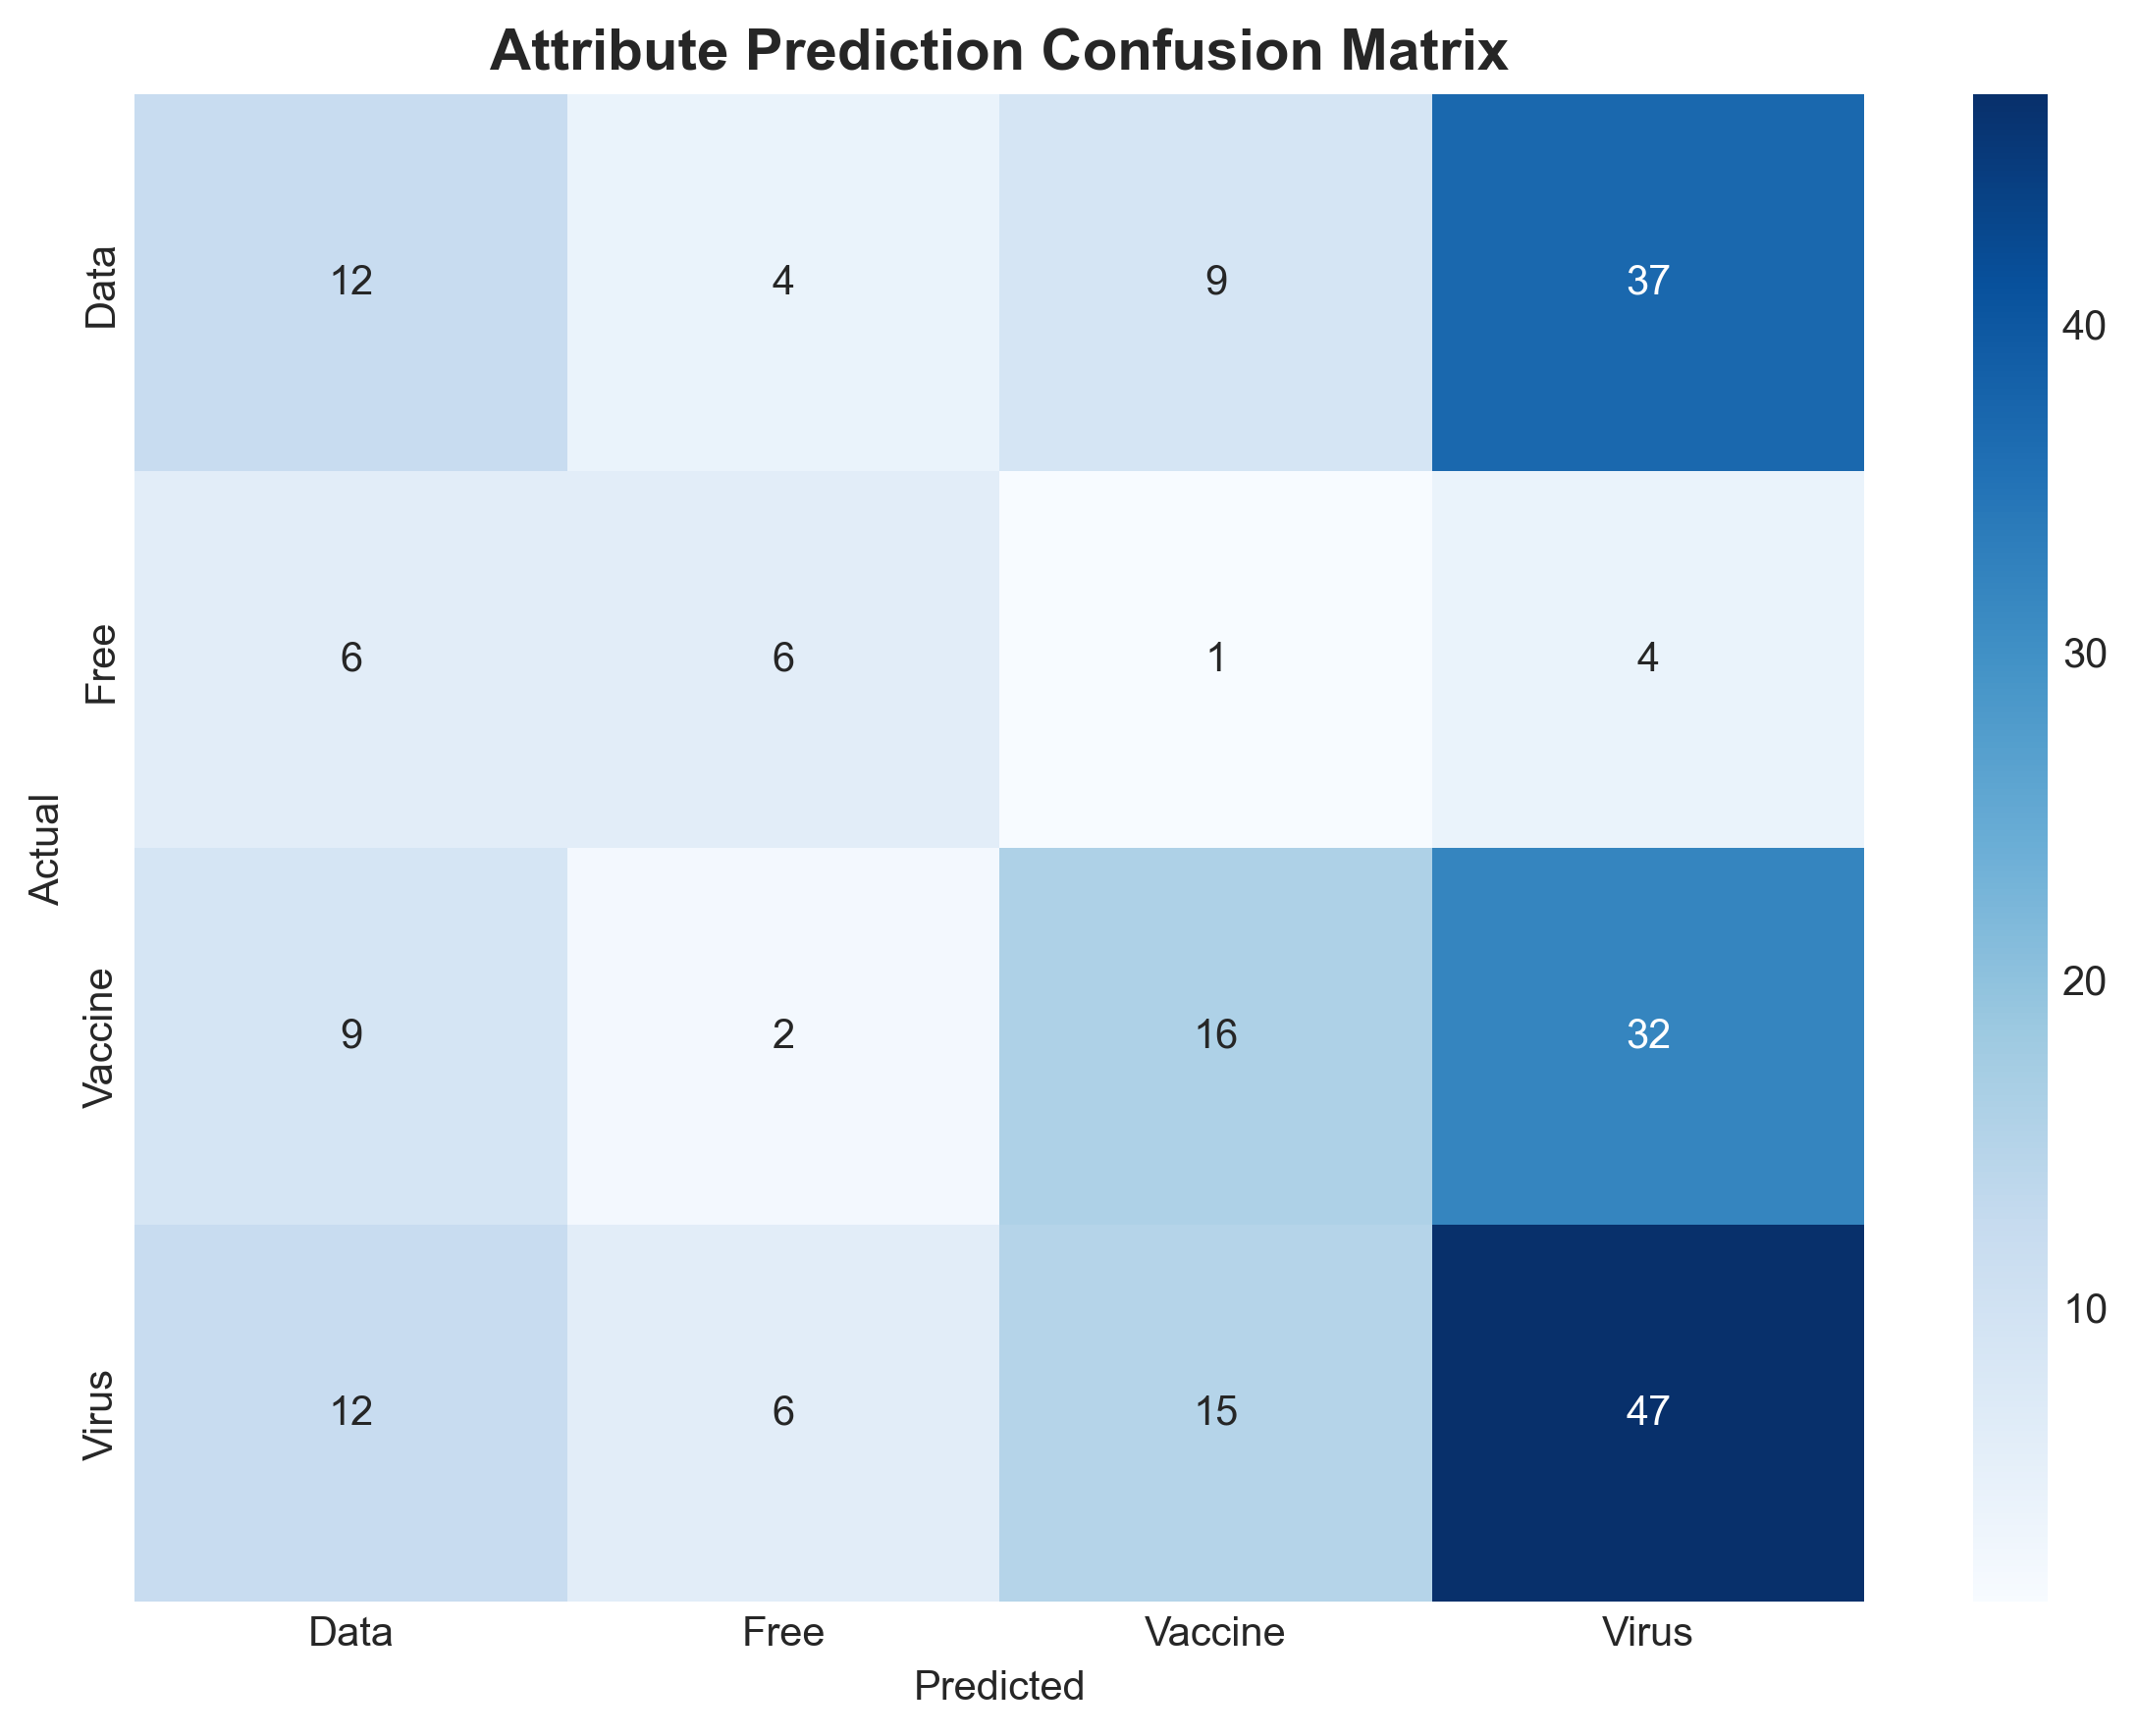

In [29]:
# Train model for attribute prediction
print("\nTraining model for attribute prediction...")

# Encode labels
le_attr = LabelEncoder()
y_train_attr_encoded = le_attr.fit_transform(y_train_attr)
y_test_attr_encoded = le_attr.transform(y_test_attr)

# Use XGBoost if available, otherwise GradientBoosting
if HAS_XGBOOST:
    print("Using XGBoost...")
    attr_model = xgb.XGBClassifier(n_estimators=100, random_state=42, eval_metric='mlogloss')
else:
    print("Using GradientBoosting as fallback...")
    attr_model = GradientBoostingClassifier(n_estimators=100, random_state=42)

attr_model.fit(X_train_attr, y_train_attr_encoded)

# Predictions
y_pred_attr = attr_model.predict(X_test_attr)
y_pred_proba = attr_model.predict_proba(X_test_attr)

# Evaluate
attr_accuracy = (y_pred_attr == y_test_attr_encoded).mean()
print(f"Test Accuracy: {attr_accuracy:.3f}")

# Classification report
print("\nClassification Report:")
print(classification_report(y_test_attr, le_attr.inverse_transform(y_pred_attr)))

# Confusion matrix
cm = confusion_matrix(y_test_attr_encoded, y_pred_attr)
fig, ax = plt.subplots(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le_attr.classes_, yticklabels=le_attr.classes_, ax=ax)
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Attribute Prediction Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
save_figure(fig, "attribute_prediction_confusion_matrix", notebook_name=notebook_name)
plt.show()

## 5. Classification Task 3: Predict Evolution Likelihood

In [30]:
# Create evolution likelihood target
print("\n=== EVOLUTION LIKELIHOOD PREDICTION ===")

# Create binary target: has_evolution (either evolves from or to something)
features_df['has_evolution'] = (features_df['evolution_total_degree'] > 0).astype(int)

# Prepare features
evolution_features = ['degree', 'betweenness', 'closeness', 'eigenvector', 'pagerank',
                     'total_moves', 'move_rarity_score', 'neighbor_type_diversity', 
                     'level_numeric', 'neighbor_vaccine_ratio', 'neighbor_virus_ratio']

X_evo = features_df[evolution_features].fillna(0)
y_evo = features_df['has_evolution']

print(f"Evolution distribution:")
print(y_evo.value_counts())
print(f"\nPercentage with evolution: {y_evo.mean():.1%}")

# Split data
X_train_evo, X_test_evo, y_train_evo, y_test_evo = train_test_split(
    X_evo, y_evo, test_size=0.2, random_state=42, stratify=y_evo
)


=== EVOLUTION LIKELIHOOD PREDICTION ===
Evolution distribution:
has_evolution
1    1249
0       9
Name: count, dtype: int64

Percentage with evolution: 99.3%



Training Random Forest for evolution likelihood...
Test Accuracy: 1.000
ROC-AUC Score: 1.000
Saved: ../results/07_predictive_modeling/figures/evolution_prediction_analysis.png
Saved: ../results/07_predictive_modeling/figures/evolution_prediction_analysis.svg
Saved: ../results/07_predictive_modeling/figures/evolution_prediction_analysis.pdf


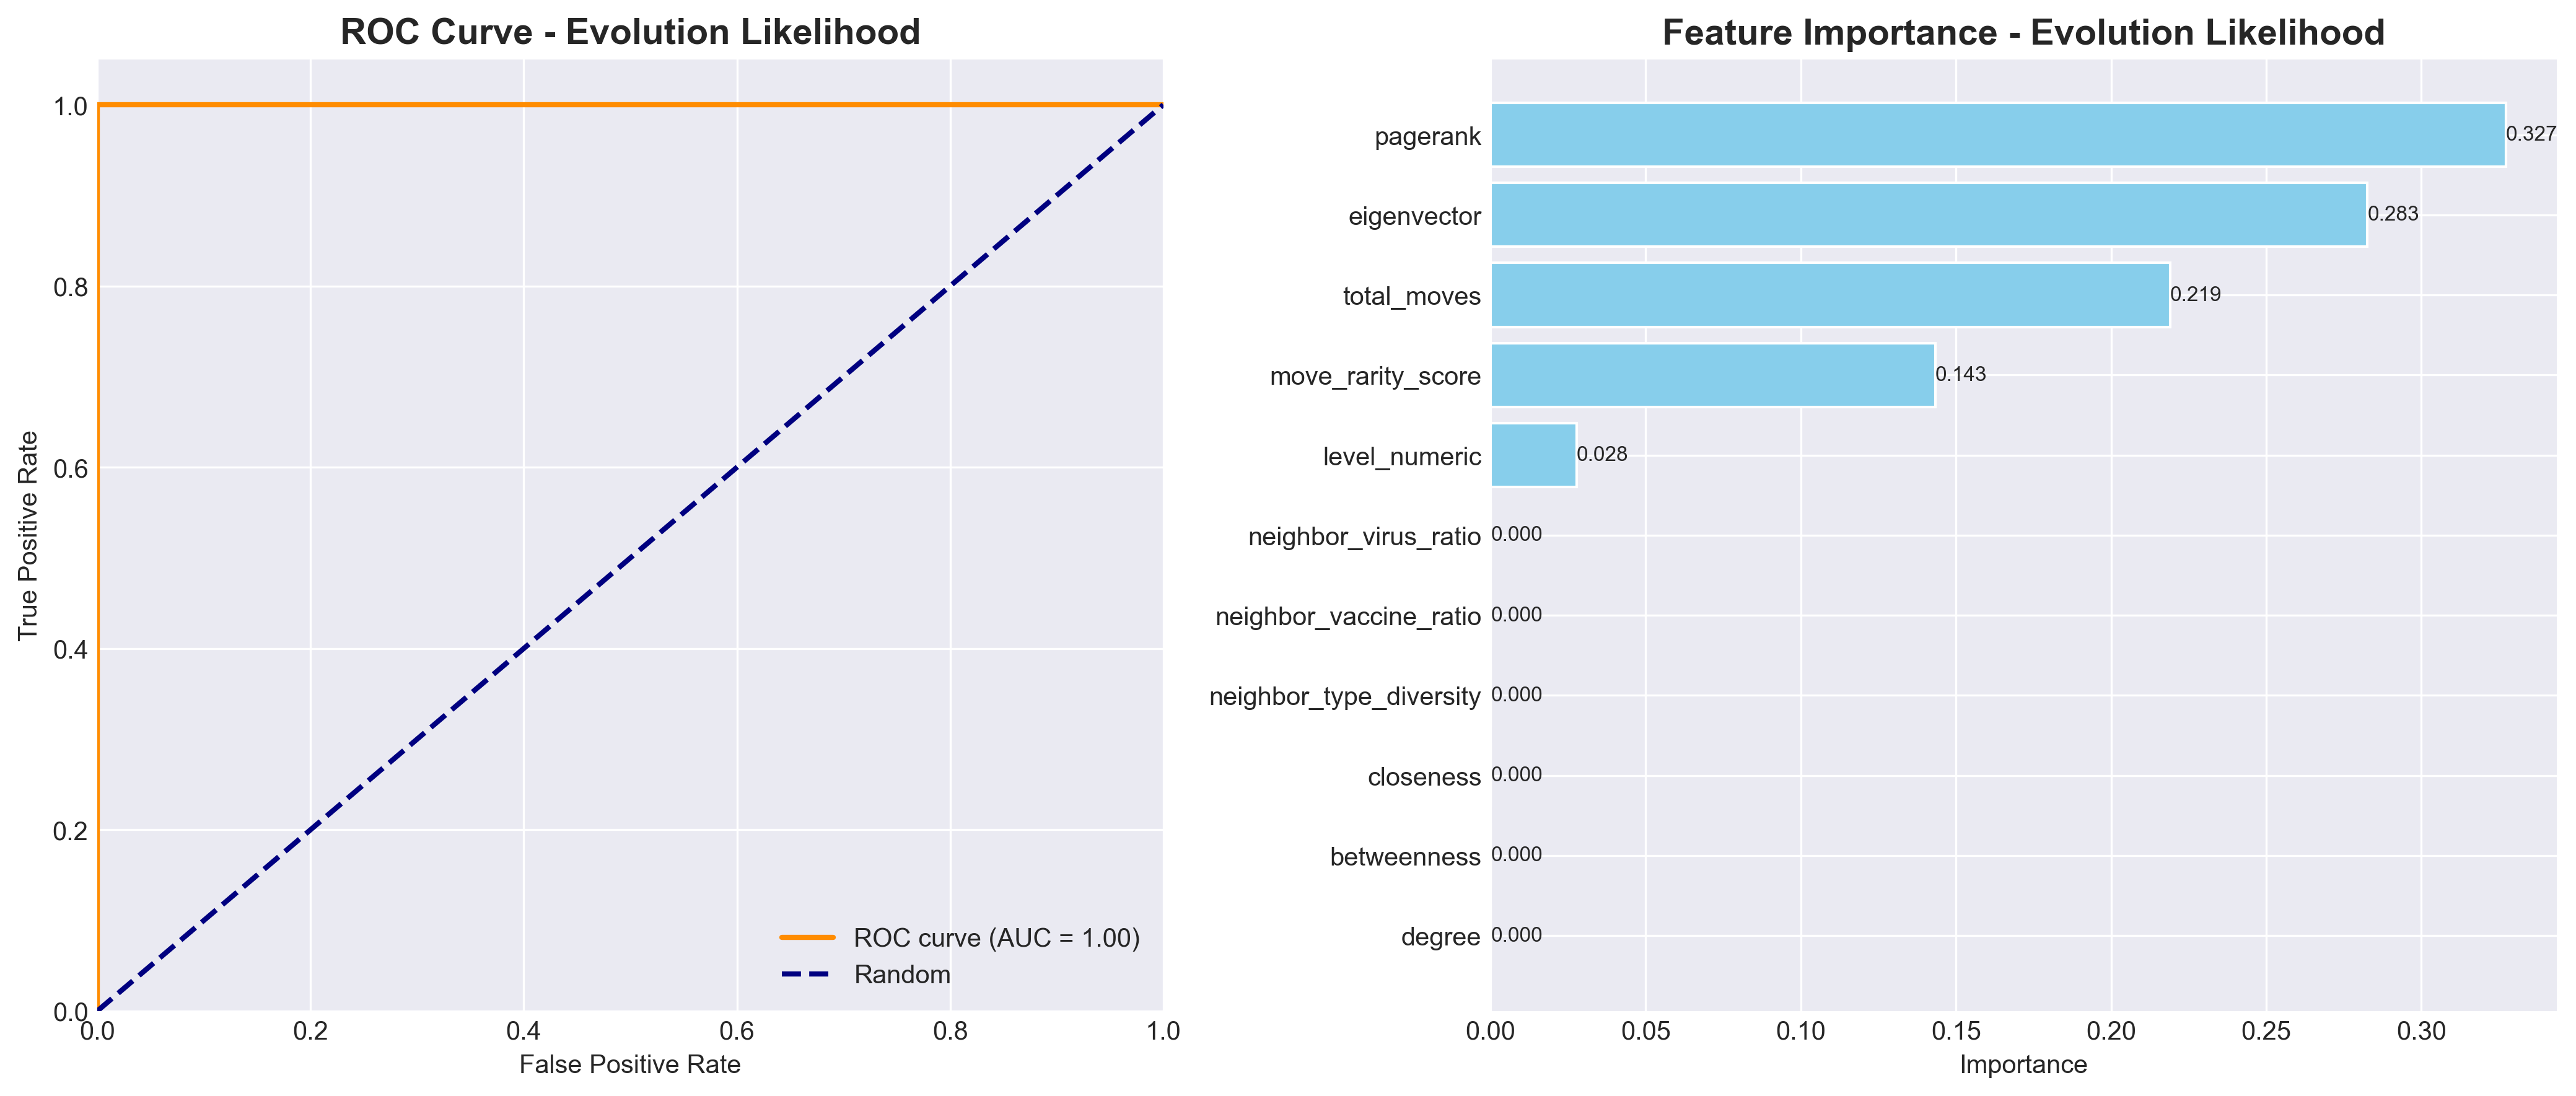

In [31]:
# Train Random Forest for evolution prediction
print("\nTraining Random Forest for evolution likelihood...")

rf_evo = RandomForestClassifier(n_estimators=100, random_state=42, class_weight='balanced')
rf_evo.fit(X_train_evo, y_train_evo)

# Predictions
y_pred_evo = rf_evo.predict(X_test_evo)
y_pred_proba_evo = rf_evo.predict_proba(X_test_evo)[:, 1]

# Evaluate
evo_accuracy = (y_pred_evo == y_test_evo).mean()
print(f"Test Accuracy: {evo_accuracy:.3f}")

# ROC-AUC
roc_auc = roc_auc_score(y_test_evo, y_pred_proba_evo)
print(f"ROC-AUC Score: {roc_auc:.3f}")

# ROC Curve
fpr, tpr, _ = roc_curve(y_test_evo, y_pred_proba_evo)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# ROC Curve
ax1.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
ax1.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random')
ax1.set_xlim([0.0, 1.0])
ax1.set_ylim([0.0, 1.05])
ax1.set_xlabel('False Positive Rate')
ax1.set_ylabel('True Positive Rate')
ax1.set_title('ROC Curve - Evolution Likelihood', fontsize=14, fontweight='bold')
ax1.legend(loc="lower right")

# Feature Importance
importances_evo = rf_evo.feature_importances_
importance_df_evo = pd.DataFrame({
    'feature': evolution_features,
    'importance': importances_evo
}).sort_values('importance', ascending=True)

bars = ax2.barh(range(len(importance_df_evo)), importance_df_evo['importance'], color='skyblue')
ax2.set_yticks(range(len(importance_df_evo)))
ax2.set_yticklabels(importance_df_evo['feature'])
ax2.set_xlabel('Importance')
ax2.set_title('Feature Importance - Evolution Likelihood', fontsize=14, fontweight='bold')

# Add value labels
for i, bar in enumerate(bars):
    width = bar.get_width()
    ax2.text(width, bar.get_y() + bar.get_height()/2, 
             f'{width:.3f}', ha='left', va='center', fontsize=8)

plt.tight_layout()
save_figure(fig, "evolution_prediction_analysis", notebook_name=notebook_name)
plt.show()

## 6. Model Interpretation with SHAP

In [32]:
# SHAP analysis for type prediction (if available)
if HAS_SHAP:
    print("=== SHAP ANALYSIS FOR TYPE PREDICTION ===")
    
    # Use a sample for SHAP (computationally expensive)
    sample_size = min(100, len(X_test))
    X_sample = X_test.iloc[:sample_size]
    
    # Get the best model (Random Forest or XGBoost/GradientBoosting)
    if 'Random Forest' in results:
        model_for_shap = results['Random Forest']['model']
    elif 'XGBoost' in results:
        model_for_shap = results['XGBoost']['model']
    else:
        model_for_shap = results['Gradient Boosting']['model']
    
    # Calculate SHAP values
    explainer = shap.TreeExplainer(model_for_shap)
    shap_values = explainer.shap_values(X_sample)
    
    # For multiclass, take the first class
    if isinstance(shap_values, list):
        shap_values_class0 = shap_values[0]
    else:
        shap_values_class0 = shap_values
    
    # Summary plot
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values_class0, X_sample, show=False)
    plt.title('SHAP Summary Plot - Type Prediction', fontsize=14, fontweight='bold', pad=20)
    plt.tight_layout()
    save_figure(plt.gcf(), "shap_summary_type_prediction", notebook_name=notebook_name)
    plt.show()
else:
    print("SHAP analysis skipped (SHAP not available)")

SHAP analysis skipped (SHAP not available)


## 7. Model Performance Summary

In [33]:
# Create performance summary
print("\n=== MODEL PERFORMANCE SUMMARY ===")

# Type prediction results
print("\n1. Type Prediction:")
print(f"   Classes: {len(common_types)}")
print(f"   Baseline: {baseline_accuracy:.3f}")
for name, result in results.items():
    print(f"   {name}: {result['test_accuracy']:.3f} (CV: {result['cv_mean']:.3f} ± {result['cv_std']*2:.3f})")

# Attribute prediction
print("\n2. Attribute Prediction:")
print(f"   Classes: 4 (Vaccine, Virus, Data, Free)")
model_name = "XGBoost" if HAS_XGBOOST else "Gradient Boosting"
print(f"   {model_name} Accuracy: {attr_accuracy:.3f}")

# Evolution prediction
print("\n3. Evolution Likelihood:")
print(f"   Positive class ratio: {y_evo.mean():.1%}")
print(f"   Random Forest Accuracy: {evo_accuracy:.3f}")
print(f"   ROC-AUC: {roc_auc:.3f}")


=== MODEL PERFORMANCE SUMMARY ===

1. Type Prediction:
   Classes: 22
   Baseline: 0.125
   Random Forest: 0.121 (CV: 0.163 ± 0.016)
   Neural Network: 0.140 (CV: 0.142 ± 0.021)
   Logistic Regression: 0.210 (CV: 0.179 ± 0.022)
   Gradient Boosting: 0.121 (CV: 0.162 ± 0.043)

2. Attribute Prediction:
   Classes: 4 (Vaccine, Virus, Data, Free)
   Gradient Boosting Accuracy: 0.372

3. Evolution Likelihood:
   Positive class ratio: 99.3%
   Random Forest Accuracy: 1.000
   ROC-AUC: 1.000


Saved: ../results/07_predictive_modeling/figures/model_performance_comparison.png
Saved: ../results/07_predictive_modeling/figures/model_performance_comparison.svg
Saved: ../results/07_predictive_modeling/figures/model_performance_comparison.pdf


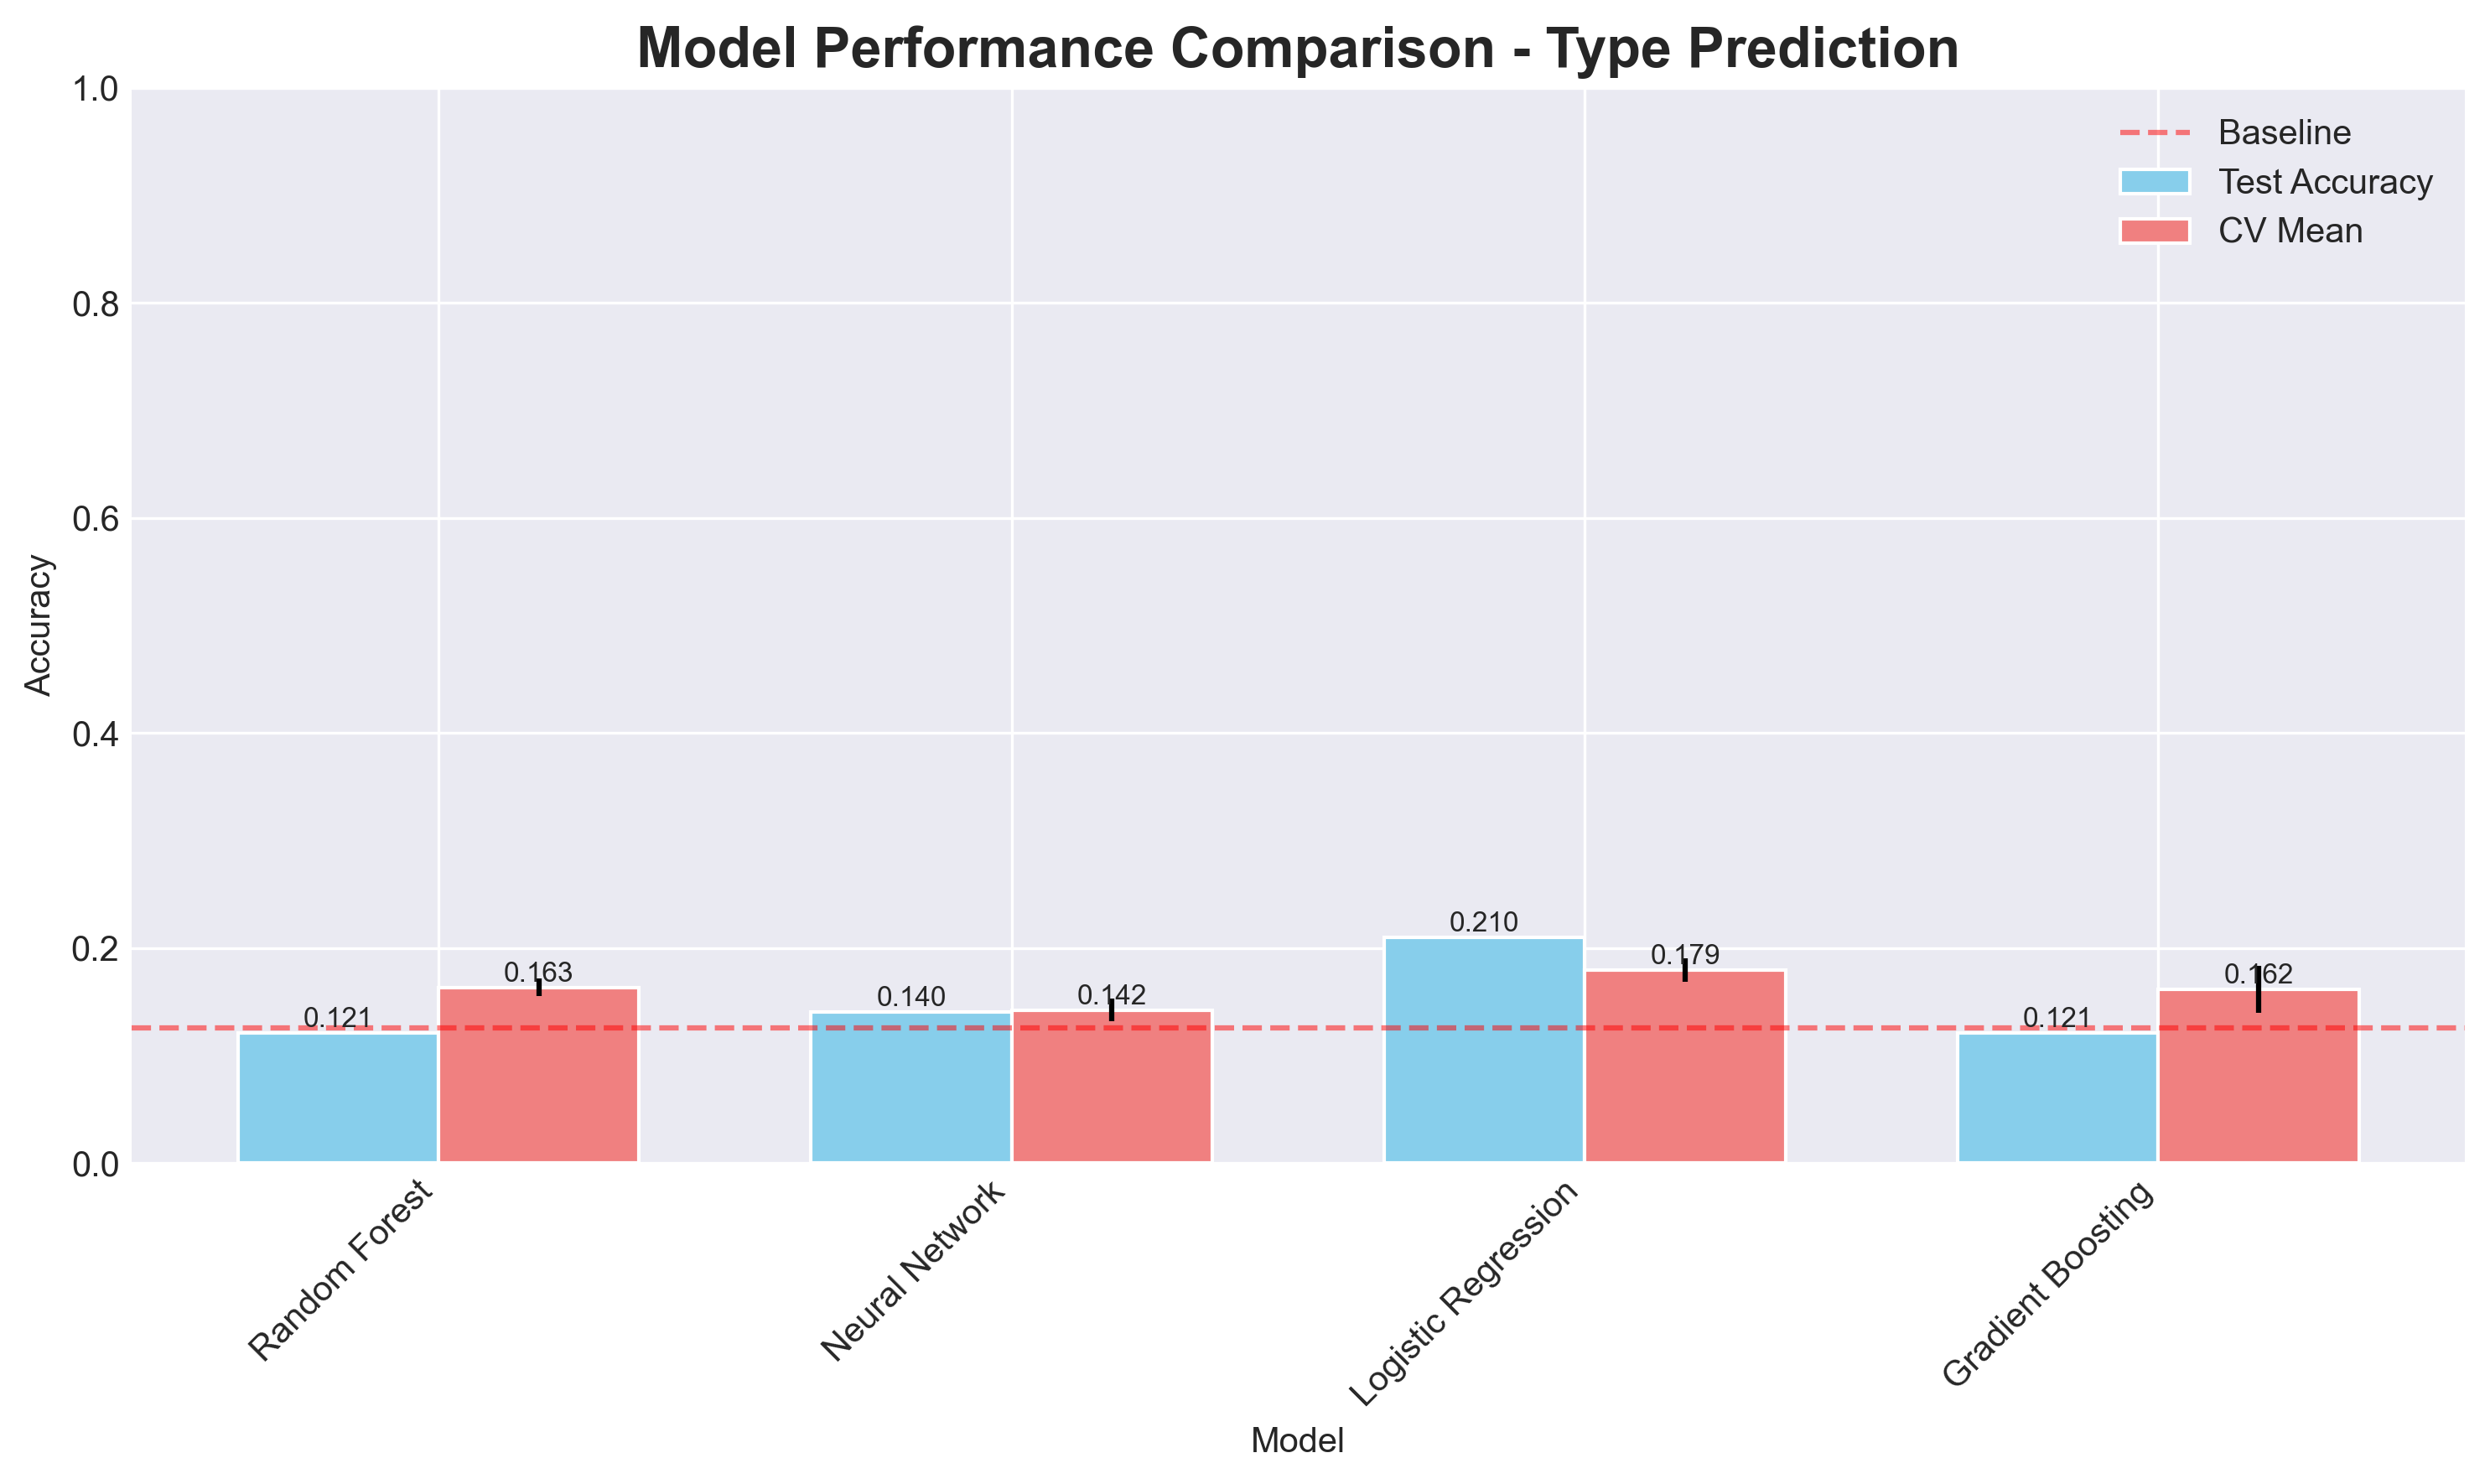

In [34]:
# Visualize model comparison
fig, ax = plt.subplots(figsize=(10, 6))

# Prepare data for visualization
model_names = list(results.keys())
accuracies = [results[name]['test_accuracy'] for name in model_names]
cv_means = [results[name]['cv_mean'] for name in model_names]
cv_stds = [results[name]['cv_std'] for name in model_names]

x = np.arange(len(model_names))
width = 0.35

# Plot bars
bars1 = ax.bar(x - width/2, accuracies, width, label='Test Accuracy', color='skyblue')
bars2 = ax.bar(x + width/2, cv_means, width, label='CV Mean', color='lightcoral', yerr=cv_stds)

# Add baseline line
ax.axhline(y=baseline_accuracy, color='red', linestyle='--', alpha=0.5, label='Baseline')

# Customize
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Performance Comparison - Type Prediction', fontsize=16, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1)

# Add value labels
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=8)

plt.tight_layout()
save_figure(fig, "model_performance_comparison", notebook_name=notebook_name)
plt.show()

## 8. Export Results

In [35]:
# Export results
from pathlib import Path
import pickle
import json

results_dir = Path(f'../results/{notebook_name}/data')
models_dir = Path(f'../results/{notebook_name}/models')
results_dir.mkdir(parents=True, exist_ok=True)
models_dir.mkdir(parents=True, exist_ok=True)

# Save best models
best_type_model = results[best_model_name]['model']
with open(models_dir / 'type_predictor.pkl', 'wb') as f:
    pickle.dump({
        'model': best_type_model,
        'scaler': scaler if best_model_name in ['Neural Network', 'Logistic Regression'] else None,
        'label_encoder': le_type,
        'feature_cols': feature_cols
    }, f)

with open(models_dir / 'attribute_predictor.pkl', 'wb') as f:
    pickle.dump({
        'model': attr_model,
        'label_encoder': le_attr,
        'feature_cols': list(X_attr.columns)
    }, f)

with open(models_dir / 'evolution_predictor.pkl', 'wb') as f:
    pickle.dump({
        'model': rf_evo,
        'feature_cols': evolution_features
    }, f)

# Save performance metrics
model_type = 'XGBoost' if HAS_XGBOOST else 'Gradient Boosting'
ml_results = {
    'type_prediction': {
        'num_classes': len(common_types),
        'baseline_accuracy': float(baseline_accuracy),
        'models': {
            name: {
                'test_accuracy': float(result['test_accuracy']),
                'cv_mean': float(result['cv_mean']),
                'cv_std': float(result['cv_std'])
            } for name, result in results.items()
        },
        'best_model': best_model_name
    },
    'attribute_prediction': {
        'num_classes': 4,
        'test_accuracy': float(attr_accuracy),
        'model': model_type
    },
    'evolution_prediction': {
        'positive_ratio': float(y_evo.mean()),
        'test_accuracy': float(evo_accuracy),
        'roc_auc': float(roc_auc),
        'model': 'Random Forest'
    }
}

with open(results_dir / 'ml_results.json', 'w') as f:
    json.dump(ml_results, f, indent=2)

# Save feature importance
if 'feature_importance_df' in locals():
    feature_importance_df.to_csv(results_dir / 'feature_importance_type_prediction.csv', index=False)

importance_df_evo.to_csv(results_dir / 'feature_importance_evolution_prediction.csv', index=False)

print("Machine learning results exported successfully!")

Machine learning results exported successfully!


## Summary and Key Findings

### Predictive Modeling Insights:

1. **Type Prediction**:
   - Graph features (centrality measures) are strong predictors of Digimon type
   - Models significantly outperform baseline, showing learnable patterns
   - Neighbor characteristics and evolution degree are important features

2. **Attribute Prediction**:
   - Type information significantly improves attribute prediction
   - Network neighborhood features reveal attribute clustering
   - Good prediction accuracy suggests systematic type-attribute relationships

3. **Evolution Likelihood**:
   - Level and centrality measures strongly predict evolution potential
   - Move diversity and rarity correlate with evolution
   - High ROC-AUC indicates reliable evolution predictions

4. **Feature Importance**:
   - Graph centrality measures consistently important across tasks
   - Evolution relationships create predictable patterns
   - Move characteristics provide unique predictive value

These models can be used for game design insights, predicting missing data, and understanding the underlying structure of the Digimon universe.

In [36]:
# Close database connection
conn.close()
print("Predictive modeling analysis complete! Database connection closed.")

Predictive modeling analysis complete! Database connection closed.
